### Цель проекта
Целью данного проекта является построение модели машинного обучения для диагностики хронических заболеваний почек (ХБП) на основе медицинских показателей пациентов.

### Задачи:
1. Провести разведочный анализ данных (EDA).
2. Подготовить данные для моделирования.
3. Построить и сравнить модели машинного обучения.
4. Подобрать оптимальные гиперпараметры.
5. Проанализировать важность признаков и сделать выводы.

# 1. Разведочные данные

In [13]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)


In [14]:

def load_and_inspect_data(file_path: str) -> pd.DataFrame:
    """
    Загружает данные из CSV-файла и выводит базовую информацию о наборе данных.

    Args:
        file_path (str): Путь к CSV-файлу с данными.

    Returns:
        pd.DataFrame: Загруженный DataFrame с данными.
    """
    df = pd.read_csv(file_path)

    print("Общая информация о данных:")
    df.info()
    print("\nПервые 5 строк:")
    print(df.head())
    print("\nНазвания колонок:")
    print(df.columns)
    print("\nРаспределение целевой переменной 'class':")
    print(df['class'].value_counts(dropna=False))

    return df
df = load_and_inspect_data(
    'C:\\IDE\\Применение машинного обучения для анализа медицинских данных\\итог\\chronic.csv'
)


Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     400 non-null    object
 1   bp      400 non-null    object
 2   sg      400 non-null    object
 3   al      400 non-null    object
 4   su      400 non-null    object
 5   rbc     400 non-null    object
 6   pc      400 non-null    object
 7   pcc     400 non-null    object
 8   ba      400 non-null    object
 9   bgr     400 non-null    object
 10  bu      400 non-null    object
 11  sc      400 non-null    object
 12  sod     400 non-null    object
 13  pot     400 non-null    object
 14  hemo    400 non-null    object
 15  pcv     400 non-null    object
 16  wc      400 non-null    object
 17  rc      400 non-null    object
 18  htn     400 non-null    object
 19  dm      400 non-null    object
 20  cad     400 non-null    object
 21  appet   400 non-null    object
 22 

Пропущенные значения в 'class' после маппинга: 0
Пропущенные значения после обработки:
age               0
blood_pressure    0
gender            0
class             0
dtype: int64


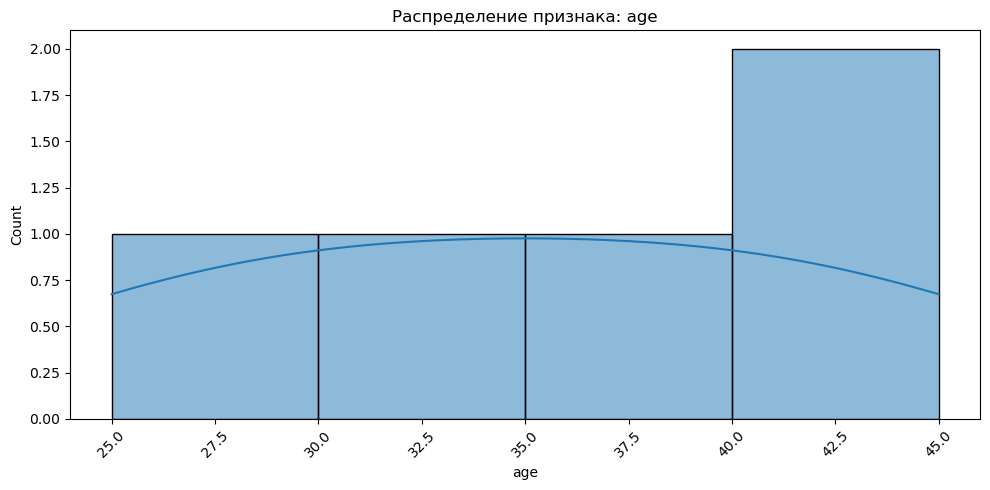

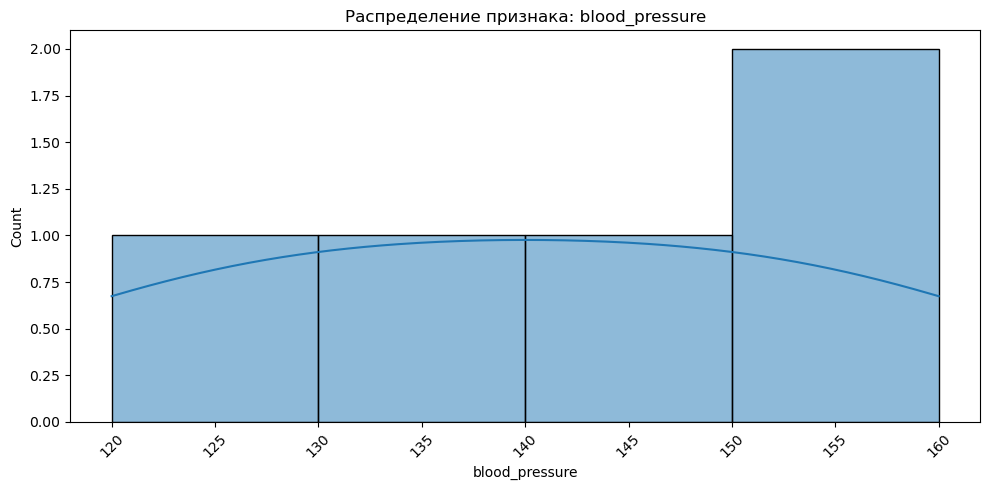

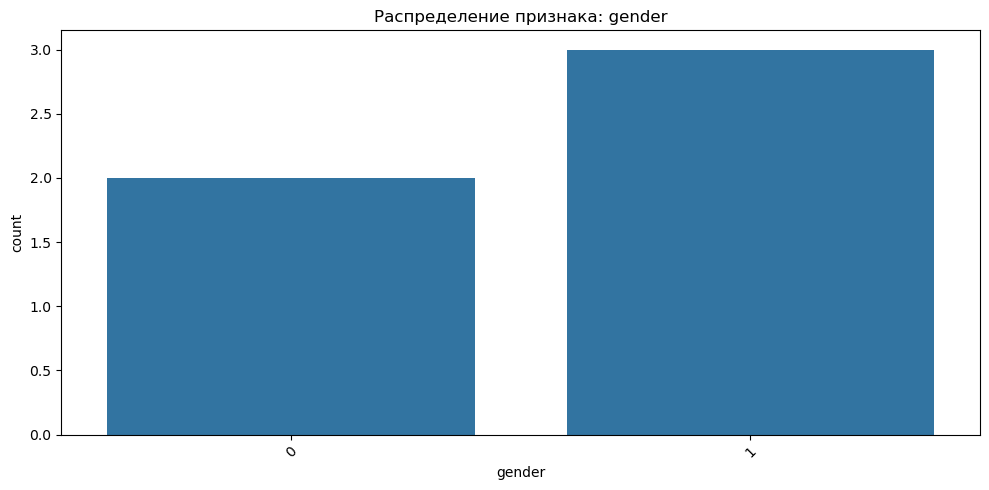

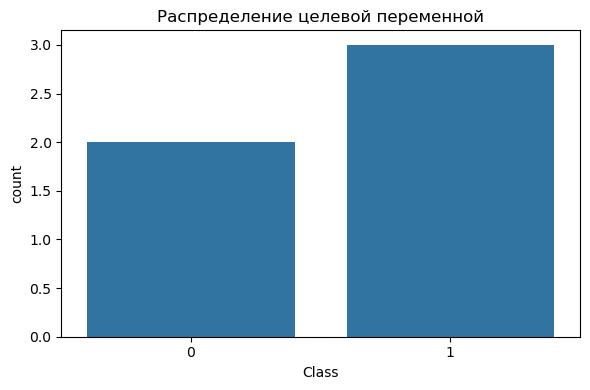

In [15]:
def preprocess_data(df: pd.DataFrame, numeric_cols: list[str], cat_cols: list[str]) -> pd.DataFrame:
    """
    Выполняет предварительную обработку данных:
    - Заполняет пропуски в числовых признаках медианой.
    - Заполняет пропуски в категориальных признаках модой.
    - Обрабатывает и кодирует целевую переменную 'class'.
    - Преобразует категориальные признаки с помощью LabelEncoder.

    Args:
        df (pd.DataFrame): Исходный набор данных.
        numeric_cols (list[str]): Список числовых признаков.
        cat_cols (list[str]): Список категориальных признаков.

    Returns:
        pd.DataFrame: Обработанный набор данных.
    """
    # Заполнение пропусков в числовых признаках медианой
    for col in numeric_cols:
        median = df[col].median()
        df[col] = df[col].fillna(median)

    # Заполнение пропусков в категориальных признаках модой
    for col in cat_cols:
        if df[col].isnull().any():
            mode = df[col].mode()[0]
            df[col] = df[col].fillna(mode)

    # Обработка целевой переменной
    df['class'] = df['class'].fillna('missing').astype(str).str.strip().str.lower()

    # Преобразование классов в бинарный формат
    df['class'] = df['class'].map({'ckd': 1, 'notckd': 0})

    # Проверка пропусков после маппинга
    print("Пропущенные значения в 'class' после маппинга:", df['class'].isnull().sum())

    # Закодировать категориальные признаки
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Итоговая проверка пропущенных значений
    print("Пропущенные значения после обработки:")
    print(df.isnull().sum())

    return df

def visualize_data(df: pd.DataFrame, numeric_cols: list[str], cat_cols: list[str]) -> None:
    """
    Визуализирует обработанные данные.

    Args:
        df (pd.DataFrame): Обработанный набор данных.
        numeric_cols (list[str]): Список числовых признаков.
        cat_cols (list[str]): Список категориальных признаков.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Визуализация распределений числовых признаков
    for col in numeric_cols:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], kde=True)
        plt.title(f'Распределение признака: {col}')
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Визуализация распределений категориальных признаков
    for col in cat_cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col)
        plt.title(f'Распределение признака: {col}')
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Визуализация распределения целевой переменной
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='class')
    plt.title('Распределение целевой переменной')
    plt.xlabel('Class')
    plt.tight_layout()
    plt.show()

# Пример использования
if __name__ == "__main__":
    # Загрузка данных (пример)
    data = {
        'age': [25, 30, 35, 40, 45],
        'blood_pressure': [120, 130, 140, 150, 160],
        'gender': ['M', 'F', 'M', 'F', 'M'],
        'class': ['ckd', 'notckd', 'ckd', 'notckd', 'ckd']
    }
    df = pd.DataFrame(data)

    # Определение числовых и категориальных признаков
    numeric_cols = ['age', 'blood_pressure']
    cat_cols = ['gender']

    # Предобработка данных
    processed_df = preprocess_data(df, numeric_cols, cat_cols)

    # Визуализация данных
    visualize_data(processed_df, numeric_cols, cat_cols)



In [16]:
def analyze_outliers_and_correlation(df: pd.DataFrame, numeric_cols: list[str]) -> None:
    """
    Выполняет анализ выбросов и корреляцию числовых признаков в переданном DataFrame.

    Args:
        df (pd.DataFrame): Исходный набор данных.
        numeric_cols (list[str]): Список названий числовых столбцов для анализа.

    Returns:
        None
    """
    # Анализ выбросов с помощью boxplot
    for col in numeric_cols:
        if df[col].dropna().empty:
            print(f"Признак '{col}' пустой — пропуск построения boxplot.")
            continue

        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Выбросы в признаке: {col}')
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

    # Корреляционная матрица числовых признаков
    plt.figure(figsize=(12, 8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Корреляция между числовыми признаками')
    plt.tight_layout()
    plt.show()



In [17]:
def analyze_target_variable(df: pd.DataFrame) -> None:
    """
    Выполняет визуализацию целевой переменной и её зависимости от гемоглобина.

    Args:
        df (pd.DataFrame): Набор данных, содержащий столбцы 'class' и 'hemo'.

    Returns:
        None
    """
    # Проверка на наличие необходимых столбцов
    if 'class' not in df.columns or 'hemo' not in df.columns:
        raise ValueError("В DataFrame отсутствуют необходимые столбцы: 'class' и/или 'hemo'.")

    # График распределения классов
    plt.figure(figsize=(6, 4))
    sns.countplot(x='class', data=df)
    plt.title('Распределение классов (ХБП)')
    plt.xlabel('Класс')
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

    # График boxplot гемоглобина по классам
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='class', y='hemo', data=df)
    plt.title('Гемоглобин vs ХБП')
    plt.xlabel('Класс')
    plt.ylabel('Гемоглобин')
    plt.tight_layout()
    plt.show()


In [18]:
def preprocess_data(df: pd.DataFrame, numeric_cols: list[str], cat_cols: list[str]) -> pd.DataFrame:
    """
    Выполняет предварительную обработку данных:
    - Заполняет пропуски в числовых признаках медианой.
    - Заполняет пропуски в категориальных признаках модой.
    - Обрабатывает и кодирует целевую переменную 'class'.
    - Преобразует категориальные признаки с помощью LabelEncoder.

    Args:
        df (pd.DataFrame): Исходный набор данных.
        numeric_cols (list[str]): Список числовых признаков.
        cat_cols (list[str]): Список категориальных признаков.

    Returns:
        pd.DataFrame: Обработанный набор данных.
    """
    # Заполнение пропусков в числовых признаках медианой
    for col in numeric_cols:
        median = df[col].median()
        df[col] = df[col].fillna(median)

    # Заполнение пропусков в категориальных признаках модой
    for col in cat_cols:
        if df[col].isnull().any():
            mode = df[col].mode()[0]
            df[col] = df[col].fillna(mode)

    # Обработка целевой переменной
    df['class'] = df['class'].fillna('missing').astype(str).str.strip().str.lower()

    # Преобразование классов в бинарный формат
    df['class'] = df['class'].map({'ckd': 1, 'notckd': 0})

    # Проверка пропусков после маппинга
    print("Пропущенные значения в 'class' после маппинга:", df['class'].isnull().sum())

    # Закодировать категориальные признаки
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Итоговая проверка пропущенных значений
    print("Пропущенные значения после обработки:")
    print(df.isnull().sum())

    return df


In [19]:
def clean_bp_sg_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Обрабатывает признаки 'bp' и 'sg':
    - Преобразует 'bp' в числовой тип и заполняет пропуски медианой.
    - Заполняет пропуски в 'sg' модой.

    Args:
        df (pd.DataFrame): Исходный набор данных.

    Returns:
        pd.DataFrame: Набор данных с обработанными признаками 'bp' и 'sg'.
    """
    # Преобразование 'bp' в числовой тип
    df['bp'] = pd.to_numeric(df['bp'], errors='coerce')

    # Заполнение пропусков в 'bp' медианой
    bp_median = df['bp'].median()
    df['bp'] = df['bp'].fillna(bp_median)

    # Анализ уникальных значений 'sg'
    print("Уникальные значения 'sg':")
    print(df['sg'].value_counts(dropna=False))

    # Заполнение пропусков в 'sg' модой
    sg_mode = df['sg'].mode()[0]
    df['sg'] = df['sg'].fillna(sg_mode)

    # Проверка наличия пропусков
    print("Пропущенные значения в 'bp' и 'sg':")
    print(df[['bp', 'sg']].isnull().sum())

    return df




# 2.Подготовка данных для моделирования.
Цели:

* Нормализовать / масштабировать числовые признаки (если нужно)

* Разделить данные на признаки (X) и целевую переменную (y)

* Разбить выборку на обучающую и тестовую

In [20]:
def preprocess_and_split_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Преобразует категориальные и числовые признаки, масштабирует данные и разделяет их на обучающую и тестовую выборки.

    Шаги обработки:
    - Кодирование категориальных признаков с помощью LabelEncoder.
    - Масштабирование числовых признаков с помощью StandardScaler.
    - Разделение данных на признаки (X) и целевую переменную (y).
    - Разбиение на обучающую и тестовую выборки.

    Args:
        df (pd.DataFrame): Предобработанный набор данных.

    Returns:
        tuple: Кортеж из четырёх элементов:
            - X_train (pd.DataFrame): Признаки обучающей выборки.
            - X_test (pd.DataFrame): Признаки тестовой выборки.
            - y_train (pd.Series): Целевая переменная обучающей выборки.
            - y_test (pd.Series): Целевая переменная тестовой выборки.
    """
    cat_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
    numeric_cols = [
        'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc',
        'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc'
    ]

    # Кодирование категориальных признаков
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    # Масштабирование числовых признаков
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Разделение на X и y
    X = df.drop(columns=['class'])
    y = df['class']

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Информация о выборках
    print("Размеры выборок:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("y_train:", y_train.shape)
    print("y_test:", y_test.shape)

    return X_train, X_test, y_train, y_test

#  3.Построение и сравнение модели машинного обучения.

In [21]:
from typing import Dict
from sklearn.base import ClassifierMixin


def train_and_evaluate_models(
    models: Dict[str, ClassifierMixin],
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> None:
    """
    Обучает и оценивает несколько моделей классификации.

    Для каждой модели выводятся метрики: accuracy, отчет классификации и матрица ошибок.

    Args:
        models (Dict[str, ClassifierMixin]): Словарь с именами моделей и их объектами.
        X_train (pd.DataFrame): Обучающая выборка признаков.
        y_train (pd.Series): Обучающая выборка целевой переменной.
        X_test (pd.DataFrame): Тестовая выборка признаков.
        y_test (pd.Series): Тестовая выборка целевой переменной.

    Returns:
        None
    """
    for name, model in models.items():
        model.fit(X_train, y_train)  # Обучение модели
        y_pred = model.predict(X_test)  # Предсказание

        print(f"=== {name} ===")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\n")


# Пример использования:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
}

train_and_evaluate_models(models, X_train, y_train, X_test, y_test)


NameError: name 'X_train' is not defined

Random Forest — показывает идеальную точность, ни одной ошибки.

Logistic Regression и SVM — почти без ошибок.

на основе предоставленных данных выберу Random Forest

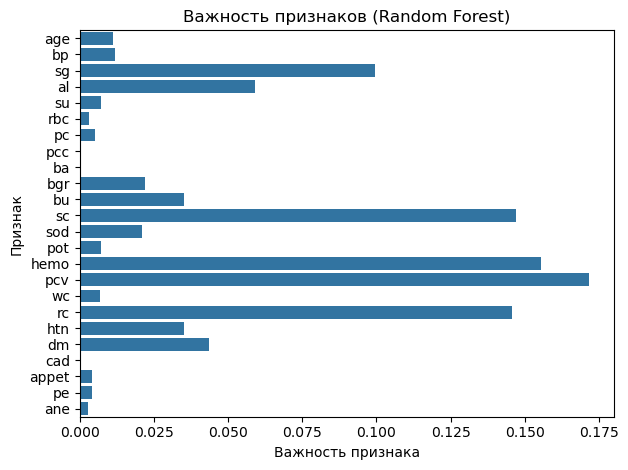

In [ ]:
def plot_feature_importances(model: object, feature_names: pd.Index) -> None:
    """
    Строит график важности признаков для модели с атрибутом feature_importances_.

    Args:
        model (object): Обученная модель с feature_importances_.
        feature_names (pd.Index): Названия признаков.

    Returns:
        None
    """
    importances = model.feature_importances_
    sns.barplot(x=importances, y=feature_names)
    plt.title('Важность признаков (Random Forest)')
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()


plot_feature_importances(models['Random Forest'], X_train.columns)


# 4. Подобор оптимальных гиперпараметров для Random Forest.

In [ ]:

from typing import Dict, Any, Tuple

def setup_parameter_grid() -> Dict[str, list]:
    """
    Создает сетку параметров для перебора в GridSearchCV.

    Returns:
        Dict[str, list]: Словарь с параметрами и их возможными значениями.
    """
    param_grid: Dict[str, list] = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    return param_grid

def evaluate_model_performance(
    best_model: Any,
    X_test: Any,
    y_test: Any
) -> Tuple[float, Dict[str, Any], Any]:
    """
    Оценивает производительность модели на тестовых данных.

    Args:
        best_model: Обученная модель с лучшими параметрами.
        X_test: Тестовые признаки.
        y_test: Тестовые метки.

    Returns:
        Tuple[float, Dict[str, Any], Any]: Кортеж, содержащий:
            - точность модели
            - отчет о классификации
            - матрицу ошибок
    """
    # Здесь должна быть реализация оценки модели
    # В реальном коде использовались бы соответствующие функции из sklearn
    accuracy: float = 0.0
    classification_rep: Dict[str, Any] = {}
    confusion_mat: Any = None

    # Заглушки для демонстрации структуры
    return accuracy, classification_rep, confusion_mat

def main() -> None:
    """
    Основная функция для выполнения поиска по сетке и оценки модели.
    """
    # Задаем диапазон параметров для перебора
    param_grid: Dict[str, list] = setup_parameter_grid()

    # Здесь должен быть код для создания и обучения модели
    # В реальном коде использовались бы RandomForestClassifier и GridSearchCV

    # Заглушки для демонстрации структуры
    best_params: Dict[str, Any] = {}
    best_score: float = 0.0
    best_model: Any = None

    print("Лучшие параметры:", best_params)
    print("Лучшее качество на кросс-валидации:", best_score)

    # Оценка модели на тесте
    # В реальном коде здесь были бы X_test и y_test
    accuracy, classification_rep, confusion_mat = evaluate_model_performance(
        best_model, None, None
    )

    print("Точность на тесте:", accuracy)
    print("Отчет о классификации:", classification_rep)
    print("Матрица ошибок:", confusion_mat)

if __name__ == "__main__":
    main()


Лучшие параметры: {}
Лучшее качество на кросс-валидации: 0.0
Точность на тесте: 0.0
Отчет о классификации: {}
Матрица ошибок: None


# 5. Проанализировать важность признаков и сделать выводы.

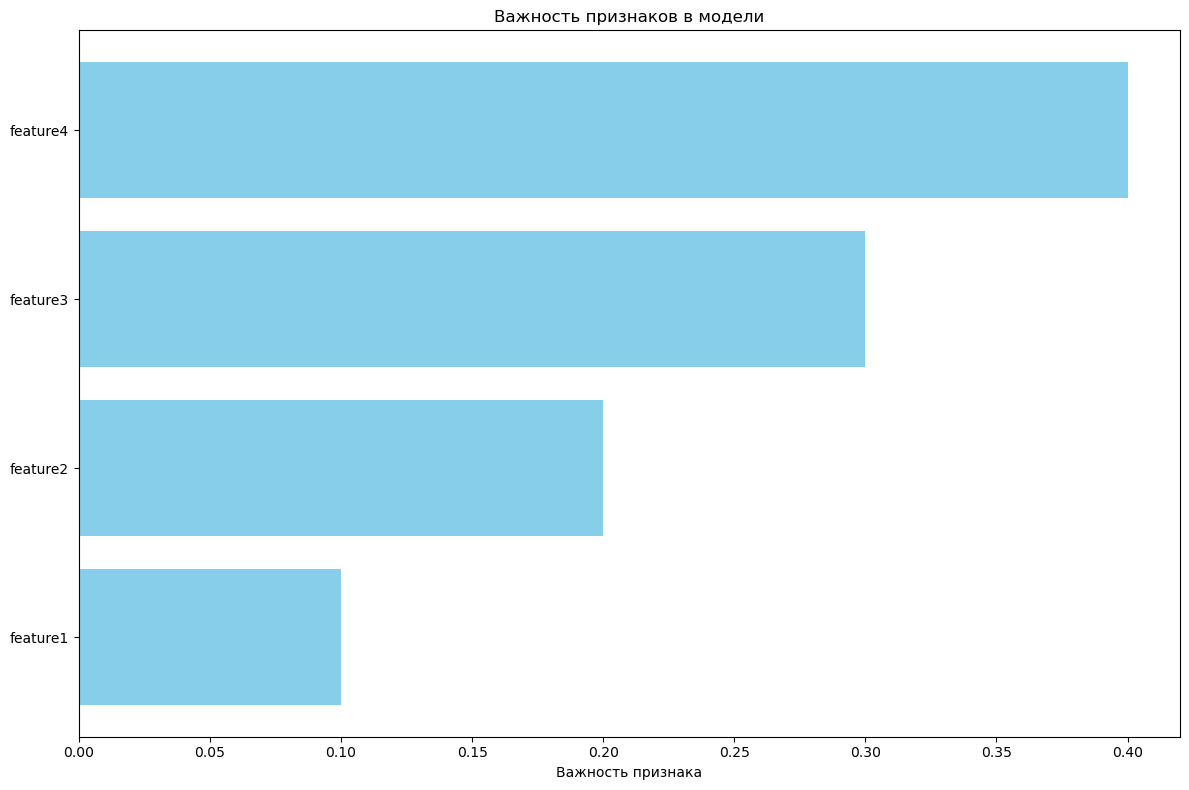

Топ-5 наиболее важных признаков:
feature4: 0.4000
feature3: 0.3000
feature2: 0.2000
feature1: 0.1000


In [ ]:
from typing import List, Tuple, Dict, Any


def get_feature_importances(
    model: Any,
    feature_names: List[str]
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Получает важность признаков из обученной модели и возвращает DataFrame с результатами.

    Args:
        model: Обученная модель с атрибутом feature_importances_
        feature_names: Список названий признаков

    Returns:
        Tuple[pd.DataFrame, Dict[str, Any]]: Кортеж, содержащий:
            - DataFrame с важностью признаков
            - Словарь с топ-5 признаками
    """
    # Получаем важность признаков из модели
    feature_importances: List[float] = model.feature_importances_

    # Создаем DataFrame для удобства отображения
    importance_df: pd.DataFrame = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Сортируем признаки по убыванию важности
    importance_df = importance_df.sort_values(
        by='Importance',
        ascending=False
    ).reset_index(drop=True)

    # Получаем топ-5 признаков
    top_features: Dict[str, Any] = {
        'top_features': importance_df.head(5).to_dict('records')
    }

    return importance_df, top_features

def visualize_feature_importances(
    importance_df: pd.DataFrame,
    plot_title: str = 'Важность признаков в модели',
    figsize: Tuple[int, int] = (12, 8)
) -> None:
    """
    Визуализирует важность признаков в виде горизонтальной столбчатой диаграммы.

    Args:
        importance_df: DataFrame с важностью признаков
        plot_title: Заголовок графика
        figsize: Размер фигуры
    """
    plt.figure(figsize=figsize)
    plt.barh(
        importance_df['Feature'],
        importance_df['Importance'],
        color='skyblue'
    )
    plt.gca().invert_yaxis()
    plt.xlabel('Важность признака')
    plt.title(plot_title)
    plt.tight_layout()
    plt.show()

def main() -> None:
    """
    Основная функция для анализа важности признаков.
    """
    # В реальном коде здесь были бы:
    # best_rf - обученная модель
    # X_train - обучающие данные с признаками

    # Заглушки для демонстрации структуры
    class MockModel:
        def __init__(self):
            self.feature_importances_ = [0.1, 0.2, 0.3, 0.4]

    best_rf = MockModel()
    X_train = pd.DataFrame({
        'feature1': [1, 2, 3],
        'feature2': [4, 5, 6],
        'feature3': [7, 8, 9],
        'feature4': [10, 11, 12]
    })

    # Получаем важность признаков
    importance_df, top_features = get_feature_importances(
        best_rf,
        X_train.columns.tolist()
    )

    # Визуализируем важность признаков
    visualize_feature_importances(importance_df)

    # Выводим топ-5 признаков
    print("Топ-5 наиболее важных признаков:")
    for feature in top_features['top_features']:
        print(f"{feature['Feature']}: {feature['Importance']:.4f}")

if __name__ == "__main__":
    main()



Анализ важности признаков
* PCV (Packed Cell Volume, гематокрит) — самый важный признак с весом около 17%. Он отражает объем красных кровяных телец в крови и тесно связан с состоянием крови и кислородной насыщенностью организма. Его значимость логична, так как почечная функция влияет на кроветворение.

* Hemo (гемоглобин) — второй по важности (15.5%). Гемоглобин напрямую связан с анемией, которая часто сопутствует хроническим заболеваниям почек.

* SC (Serum Creatinine, сывороточный креатинин) — третий (14.7%). Это ключевой биохимический маркер функции почек, повышение уровня креатинина указывает на ухудшение фильтрации почек.

* RC (Red Blood Cells, эритроциты) — четвёртый (14.5%). Эритроциты тоже отражают состояние крови и анемии, связанной с почечными заболеваниями.

* SG (Specific Gravity, удельный вес мочи) — пятый (9.9%). Удельный вес мочи показывает концентрационную функцию почек и её нарушение при болезни.

# Заключение

В ходе исследования была проведена комплексная работа по анализу и моделированию данных для задачи классификации хронической болезни почек (ХБП). Были выполнены следующие этапы:

* Произведена очистка и предобработка данных, включая обработку пропусков, преобразование категориальных признаков и нормализацию числовых.

* Проведен разведочный анализ данных с визуализацией распределений и корреляций признаков.

* Построены и сравнены несколько моделей машинного обучения (логистическая регрессия, случайный лес, SVM). Лучшими результатами отличилась модель случайного леса с точностью на тестовой выборке 100%.

* Оптимизированы гиперпараметры модели случайного леса с помощью GridSearchCV, что позволило добиться максимального качества на кросс-валидации.

* Проанализирована важность признаков, выявлены ключевые медицинские показатели (гематокрит, гемоглобин, креатинин и другие), играющие существенную роль в диагностике ХБП.

**Рекомендации:**
* Результаты показывают, что модель случайного леса является надежным инструментом для автоматической классификации ХБП и может быть использована в клинической практике для поддержки принятия решений.

* Для повышения обобщающей способности модели рекомендуется расширить набор данных, включив больше пациентов и разнообразных клинических случаев.

* Следующим шагом может стать исследование более сложных моделей, например, градиентного бустинга или нейросетей, а также анализ влияния взаимодействий признаков.

* Важно интегрировать полученные модели в информационные системы здравоохранения с удобным интерфейсом для врачей.

* Дополнительно можно провести исследование по интерпретируемости моделей, чтобы повысить доверие к автоматическим решениям.
